# Spam Comments Detection

The goal of text classification in machine learning is to find spam comments. On social media platforms, spam comments are those that are left with the intention of directing the user to another social media account, website, or other piece of material.

In [1]:
# libraries

import warnings
import random

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# nlp
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import TfidfTransformer

# training model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("Youtube04-Eminem.csv")
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12rwfnyyrbsefonb232i5ehdxzkjzjs2,Lisa Wellas,NaN,+447935454150 lovely girl talk to me xxx﻿,1
1,z130wpnwwnyuetxcn23xf5k5ynmkdpjrj04,jason graham,2015-05-29T02:26:10.652000,I always end up coming back to this song<br />﻿,0
2,z13vsfqirtavjvu0t22ezrgzyorwxhpf3,Ajkal Khan,NaN,"my sister just received over 6,500 new <a rel=...",1
3,z12wjzc4eprnvja4304cgbbizuved35wxcs,Dakota Taylor,2015-05-29T02:13:07.810000,Cool﻿,0
4,z13xjfr42z3uxdz2223gx5rrzs3dt5hna,Jihad Naser,NaN,Hello I&#39;am from Palastine﻿,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  448 non-null    object
 1   AUTHOR      448 non-null    object
 2   DATE        203 non-null    object
 3   CONTENT     448 non-null    object
 4   CLASS       448 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 17.6+ KB


In [4]:
data.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

In [5]:
x = data['DATE'][1]
x

'2015-05-29T02:26:10.652000'

In [6]:
x.split("T")[1]

'02:26:10.652000'

In [7]:
d = data['DATE'].dropna()
d =  d.apply(lambda x : x.split("T")[0])
d.value_counts(ascending=False)

d.value_counts() # median is 21 therefore I'll fill the date with 2015-05-21

2015-05-21    29
2015-05-28    27
2015-05-26    27
2015-05-24    21
2015-05-23    19
2015-05-27    18
2015-05-19    17
2015-05-20    13
2015-05-25    12
2015-05-22    10
2015-05-29     4
2015-05-07     3
2015-05-06     3
Name: DATE, dtype: int64

In [8]:
from datetime import datetime

m = data['DATE'].dropna()
m =  m.apply(lambda x : x.replace("T"," "))
#m = m.apply(lambda x : x.split(".")[0])
m = m.apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f'))

hour = m.apply(lambda x : str(x).split(" ")[1])
hour = hour.apply(lambda x : str(x).split(".")[0])

#print(hour)
hour = hour.reset_index()
hour.value_counts(ascending=True) # no specific same time therefore I'll assign a random hour,minute,second

filling_time = data['DATE'].dropna().sample(1)
filling_time = filling_time.to_string()
print(filling_time)

93    2015-05-27T18:00:23.754000


In [9]:
filling_time = filling_time.split(" ")[4]
print(filling_time)

2015-05-27T18:00:23.754000


In [10]:
#data['DATE'] = data['DATE'].fillna("2015-05-21T00:00:00.000000")

data['DATE'] = data['DATE'].fillna(filling_time)
data.isnull().sum()

COMMENT_ID    0
AUTHOR        0
DATE          0
CONTENT       0
CLASS         0
dtype: int64

In [11]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12rwfnyyrbsefonb232i5ehdxzkjzjs2,Lisa Wellas,2015-05-27T18:00:23.754000,+447935454150 lovely girl talk to me xxx﻿,1
1,z130wpnwwnyuetxcn23xf5k5ynmkdpjrj04,jason graham,2015-05-29T02:26:10.652000,I always end up coming back to this song<br />﻿,0
2,z13vsfqirtavjvu0t22ezrgzyorwxhpf3,Ajkal Khan,2015-05-27T18:00:23.754000,"my sister just received over 6,500 new <a rel=...",1
3,z12wjzc4eprnvja4304cgbbizuved35wxcs,Dakota Taylor,2015-05-29T02:13:07.810000,Cool﻿,0
4,z13xjfr42z3uxdz2223gx5rrzs3dt5hna,Jihad Naser,2015-05-27T18:00:23.754000,Hello I&#39;am from Palastine﻿,1


In [12]:
data['HOUR'] = data['DATE'].apply(lambda x : x.split("T")[1])
data['HOUR'] = data['HOUR'].apply(lambda x : x.split(".")[0])

data['DATE'] = data['DATE'].apply(lambda x : x.split("T")[0])
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')

data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,HOUR
0,z12rwfnyyrbsefonb232i5ehdxzkjzjs2,Lisa Wellas,2015-05-27,+447935454150 lovely girl talk to me xxx﻿,1,18:00:23
1,z130wpnwwnyuetxcn23xf5k5ynmkdpjrj04,jason graham,2015-05-29,I always end up coming back to this song<br />﻿,0,02:26:10
2,z13vsfqirtavjvu0t22ezrgzyorwxhpf3,Ajkal Khan,2015-05-27,"my sister just received over 6,500 new <a rel=...",1,18:00:23
3,z12wjzc4eprnvja4304cgbbizuved35wxcs,Dakota Taylor,2015-05-29,Cool﻿,0,02:13:07
4,z13xjfr42z3uxdz2223gx5rrzs3dt5hna,Jihad Naser,2015-05-27,Hello I&#39;am from Palastine﻿,1,18:00:23


In order to detect spam comments we only need <b>Content</b> and <b>Class</b> features

In [13]:
data = data[['CONTENT','CLASS']]
data.head()

,CONTENT,CLASS
0,+447935454150 lovely girl talk to me xxx﻿,1
1,I always end up coming back to this song<br />﻿,0
2,"my sister just received over 6,500 new <a rel=...",1
3,Cool﻿,0
4,Hello I&#39;am from Palastine﻿,1


<b>0</b> indicates <b>NOT SPAM</b>, <b>1</b> indicates <b>SPAM</b> comments.

## Generating WordCloud for Comments

*Starting with only one comment from class 0 and class 1.*

The comment:  The perfect example of abuse from husbands and the thing is I&#39;m a feminist so I definitely agree with this song and well...if I see this someone&#39;s going to die! Just sayin.﻿


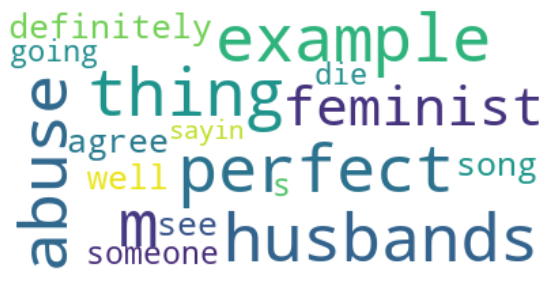

In [14]:
# NOT SPAM Example
text = data.CONTENT[13]
print("The comment: ",text)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The comment:  Alright ladies, if you like this song, then check out John Rage.  He&#39;s a smoking hot rapper coming into the game.  He&#39;s not better than Eminem lyrically, but he&#39;s hotter. Hear some of his songs on my channel.﻿


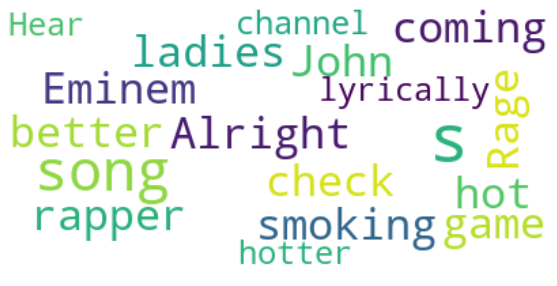

In [15]:
# SPAM Example
text = data.CONTENT[12]
print("The comment: ",text)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

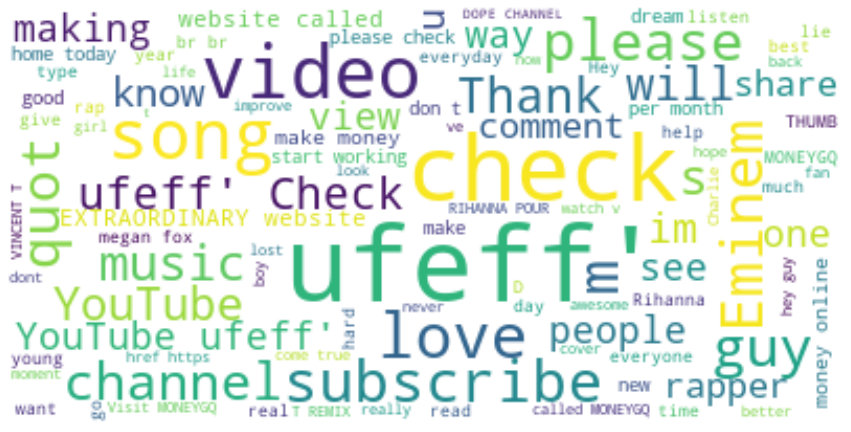

In [16]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(list(data['CONTENT'])))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Training a Classification Model

*Naive Bayes Algorithms* have a principle, that indicates every pair of features being classified is independent of each other.

In [17]:
X = np.array(data["CONTENT"])
y = np.array(data["CLASS"])

cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [18]:
# Naive Bayes classifier for multivariate Bernoulli models. Like MultinomialNB, this classifier is suitable
# for discrete data. The difference is that while MultinomialNB works with occurrence counts, 
# BernoulliNB is designed for binary/boolean features.

model = BernoulliNB() 

model.fit(X_train, y_train)
print(model.score(X_test,y_test))

0.8111111111111111


In [19]:
example = "Check this website it is wonderful blog and amazing design and style : https://github.com/melisnv"

new_df = cv.transform([example]).toarray()
print(model.predict(new_df))

[0]


# Random Forest Classifier

Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

It technically is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. This collection of decision tree classifiers is also known as the forest. The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In a classification problem, each tree votes and the most popular class is chosen as the final result. In the case of regression, the average of all the tree outputs is considered as the final result. It is simpler and more powerful compared to the other non-linear classification algorithms. [RFC](https://www.datacamp.com/tutorial/random-forests-classifier-python)

In [20]:
len(data.query('CLASS == 1'))

245

In [21]:
len(data.query('CLASS == 0'))

203

In [22]:
len(data)

448

In [23]:
vec = cv.fit_transform(data['CONTENT'])

In [24]:
analyze = cv.build_analyzer()

In [25]:
print(data['CONTENT'][13])
analyze(data['CONTENT'][13])

The perfect example of abuse from husbands and the thing is I&#39;m a feminist so I definitely agree with this song and well...if I see this someone&#39;s going to die! Just sayin.﻿


['the',
 'perfect',
 'example',
 'of',
 'abuse',
 'from',
 'husbands',
 'and',
 'the',
 'thing',
 'is',
 '39',
 'feminist',
 'so',
 'definitely',
 'agree',
 'with',
 'this',
 'song',
 'and',
 'well',
 'if',
 'see',
 'this',
 'someone',
 '39',
 'going',
 'to',
 'die',
 'just',
 'sayin']

In [26]:
data_shuffle = data.sample(frac=1)

d_train = data_shuffle[:400]
d_test = data_shuffle[400:]

d_train_att = cv.fit_transform(d_train['CONTENT']) # fit bag-of-words on training set
d_test_att = cv.transform(d_test['CONTENT']) # reuse on testing set
d_train_label = d_train['CLASS']
d_test_label = d_test['CLASS']

In [27]:
rfc = RandomForestClassifier(n_estimators=80)

In [28]:
rfc.fit(d_train_att, d_train_label)

RandomForestClassifier(n_estimators=80)

In [29]:
rfc.score(d_test_att, d_test_label)

0.9583333333333334

[[18  2]
 [ 0 28]]


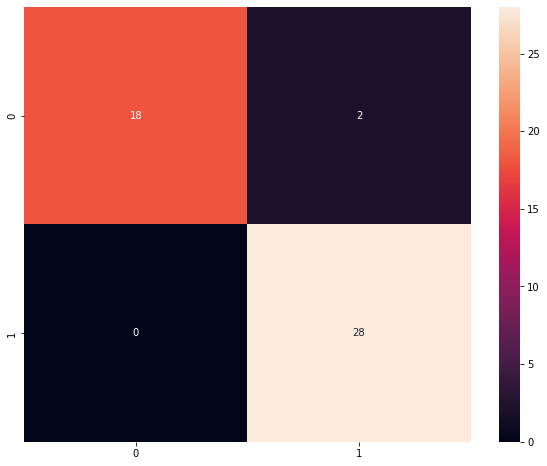

In [30]:
pred = rfc.predict(d_test_att)

print(confusion_matrix(pred,d_test_label))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(pred,d_test_label), annot=True);

In [31]:
# Evaluating a score by cross-validation
# cv determines the cross-validation splitting strategy
scores = cross_val_score(rfc, d_train_att, d_train_label,cv=5)

# average score
print("Accuracy: ", scores.mean(), scores.std() * 2)

Accuracy:  0.9575000000000001 0.05612486080160918


In [32]:
# Combining all datasets

dataf = pd.concat([pd.read_csv("Youtube01-Psy.csv"),
                  pd.read_csv("Youtube02-KatyPerry.csv"),
                  pd.read_csv("Youtube03-LMFAO.csv"),
                  pd.read_csv("Youtube04-Eminem.csv"),
                  pd.read_csv("Youtube05-Shakira.csv")])

In [33]:
dataf.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [34]:
len(dataf)

1956

In [35]:
print("Spam comments: ",len(dataf.query('CLASS == 1')))

print("Not spam comments: ",len(dataf.query('CLASS == 0')))

Spam comments:  1005
Not spam comments:  951


In [36]:
# shuffling the data

data_shuff = dataf.sample(frac=1)
d_comments = data_shuff['CONTENT']
d_labels = data_shuff['CLASS']

In [37]:
# setting up a pipeline

pipeline = Pipeline([('bag-of-words',CountVectorizer()),
                     ('random-forest', RandomForestClassifier())])

pipeline

Pipeline(steps=[('bag-of-words', CountVectorizer()),
                ('random-forest', RandomForestClassifier())])

In [38]:
# fitting the model

pipeline.fit(d_comments[:1500], d_labels[:1500])

Pipeline(steps=[('bag-of-words', CountVectorizer()),
                ('random-forest', RandomForestClassifier())])

In [39]:
pipeline.score(d_comments[1500:], d_labels[1500:])

0.9407894736842105

In [40]:
pipeline.predict(["Click here fore more"])

array([0], dtype=int64)

In [41]:
pipeline.predict(["I loved this song!"])

array([0], dtype=int64)

In [42]:
pipeline.predict(["+447935454150 lovely girl talk to me"])

array([0], dtype=int64)

In [43]:
pipeline.predict(["my sister just received over 6,500 new..."])

array([0], dtype=int64)

# TfidfTransformer

Tf means term-frequency while tf-idf means *term-frequency times inverse document-frequency*. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

In [44]:
pipeline_2 = make_pipeline(CountVectorizer(),
                           TfidfTransformer(norm=None),
                           RandomForestClassifier())

pipeline_2

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer(norm=None)),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
scores_pip2 = cross_val_score(pipeline_2, d_comments, d_labels,cv=5)

# average score
print("Accuracy: ", scores_pip2.mean(), scores_pip2.std() * 2)

Accuracy:  0.9611501122188006 0.02632492753380466


In [46]:
pipeline_2.steps

[('countvectorizer', CountVectorizer()),
 ('tfidftransformer', TfidfTransformer(norm=None)),
 ('randomforestclassifier', RandomForestClassifier())]

# Parameter Search

`Grid-search` is a process that searches exhaustively through a manually specified subset of the hyperparameter space of the targeted algorithm. `Random-search`, on the other hand, selects a value for each hyperparameter independently using a probability distribution. **Grid-search** *is used to find the optimal hyperparameters of a model which results in the most 'accurate' predictions.*

In [47]:
parameters = {
    'countvectorizer__max_features': (None, 1000, 2000),
    'countvectorizer__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'countvectorizer__stop_words': ('english', None),
    'tfidftransformer__use_idf': (True, False), # effectively turn on/off tfidf
    'randomforestclassifier__n_estimators': (20, 50, 100)
}

In [48]:
# n_jobs :  Number of jobs to run in parallel.``-1`` means using all processors.
# verbose = Controls the verbosity: the higher, the more messages.

gridsearch = GridSearchCV(pipeline_2, parameters, verbose=1, n_jobs= -1)

In [49]:
gridsearch.fit(d_comments,d_labels)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('tfidftransformer',
                                        TfidfTransformer(norm=None)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': (None, 1000, 2000),
                         'countvectorizer__ngram_range': ((1, 1), (1, 2)),
                         'countvectorizer__stop_words': ('english', None),
                         'randomforestclassifier__n_estimators': (20, 50, 100),
                         'tfidftransformer__use_idf': (True, False)},
             verbose=1)

In [50]:
print("Best score %0.3f" % gridsearch.best_score_)
print("Best parameters set: ")
best_parameters = gridsearch.best_estimator_.get_params()

for params in sorted(parameters.keys()):
    print("\t%s: %r" % (params, best_parameters[params]))

Best score 0.963
Best parameters set: 
	countvectorizer__max_features: 2000
	countvectorizer__ngram_range: (1, 1)
	countvectorizer__stop_words: 'english'
	randomforestclassifier__n_estimators: 100
	tfidftransformer__use_idf: False
